# YouTube Data API v3

### Python Libraries

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import collections

### Imported Scripts

In [7]:
    # api_key is stored in config.py
import config

    # Functions for making youtube_requests
import youtube_requests

    # Functions for data processing
import data_processing

    # Functions for creating a network graph    
import network_graphs

#import importlib
#importlib.reload(mymodule)

In [3]:
%load_ext autoreload

In [4]:
%autoreload 1

In [5]:
%aimport network_graphs

# YouTube Channel Details by Search

Returns a details list of channels for a specific search query and number of requested results.

In [43]:
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_search('Corridor',50)

# Youtube Channel Details by Network

In [46]:
CORRIDOR_RESP = CHANNELS_DETAILS_ITEMS_LIST[4]

In [ ]:
[channel['snippet']['title'] for channel in CHANNELS_DETAILS_ITEMS_LIST]

In [36]:
CORRIDOR_RESP = CHANNELS_DETAILS_ITEMS_LIST[11]

11 neighbors; 0 out of 1 channels do not feature channels
{'UCDsO-0Yo5zpJk575nKXgMVA', 'UCI4Wh0EQPjGx2jJLjmTsFBQ', 'UCoK5NOxkZBLfI_5eqf8Es4Q', 'UCb8ewylk7d2M_1dLGEiFmuQ', 'UCSpFnDQr88xCZ80N-X7t0nQ', 'UC6Je0KLSDuKLfKs1lEBzKrQ', 'UCQqi--mpTFtGNim0WCtPH-A', 'UCz_cDc_2arKIb6SlJoqFT0w', 'UCKo61AAaRD00ibCWJZ321MQ', 'UCNSeDrWRGxx5p2l3tj7RWQw', 'UCwgURKfUA7e0Z7_qE3TvBFQ'}
62 neighbors; 0 out of 11 channels do not feature channels
{'UChVTBV42Ao5krVgPMz3R9ww', 'UCSrPuHtKbst7Zy8pyWn_3Cg', 'UC6sokr_zvkvLdhTfJD2QC_w', 'UCzofNVHFCdD_4Jxs5dVqtAA', 'UCzQUP1qoWDoEbmsQxvdjxgQ', 'UCyC_4jvPzLiSkJkLIkA7B8g', 'UCRijo3ddMTht_IHyNSNXpNQ', 'UCLK5icWTfKgw6I2HIku84vg', 'UCYq-iAOSZBvoUxvfzwKIZWA', 'UCOYWgypDktXdb-HfZnSMK6A', 'UCmLpukyN1nfdEqvg1I97poQ', 'UC7XJ6Oa8IzD7j5sqJLq4Ghg', 'UCAp990eMLzmei84WNR4ptgA', 'UCUK0HBIBWgM2c4vsPhkYY4w', 'UC60zl3j4jDlwPDy73aKaCtQ', 'UCXuqSBlHAE6Xw-yeJA0Tunw', 'UC3DkFux8Iv-aYnTRWzwaiBA', 'UCY30JRSgfhYXA6i6xX1erWg', 'UCnfeQePP9wc6W9rNUvQVkwA', 'UCeldJxsHTM9ycdUT4SJsa7Q', 'UCNgSkSyLpwJ

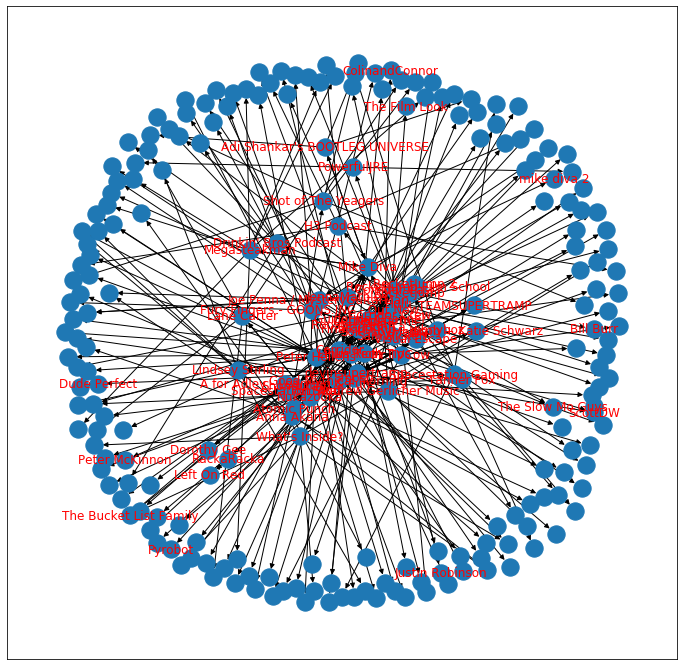

In [108]:
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_network([CORRIDOR_RESP], 2)

# Graph the network of channels
G = network_graphs.graph_channels(CHANNELS_DETAILS_ITEMS_LIST)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

In [56]:
CHANNELS_ID_LIST = [channel['id'] for channel in CHANNELS_DETAILS_ITEMS_LIST]
CHANNEL_NAMES = {channel['id']:channel['snippet']['title'] \
                   if 'title' in channel['snippet'] else [] \
                   for channel in CHANNELS_DETAILS_ITEMS_LIST}

In [ ]:
for edge in G.edges():
    print(G.nodes[edge[0]])

In [134]:
H.nodes['UChVTBV42Ao5krVgPMz3R9ww']

{'pos': array([ 0.81402831, -0.2404856 ]), 'title': 'Megasteakman'}

In [139]:
[H.nodes[node]['title'] for node in H.nodes]

['Megasteakman',
 'johnyboz',
 "What's Inside?",
 'PowerfulJRE',
 'TEAMSUPERTRAMP',
 'Lindsey Stirling',
 "Drinkin' Bros Podcast",
 'Nukazooka',
 'Jacob + Katie Schwarz',
 'Corridor Crew',
 'SoKrispyMedia',
 'Corridor Cast',
 'TomSka',
 'Spacestation Stuff',
 'Spacestation Gaming',
 'Pyrobot',
 'The Slow Mo Guys',
 'Left On Red',
 'Bill Burr',
 'Atomic Punch',
 'Peter McKinnon',
 'Smosh',
 'Linus Tech Tips',
 'Cerberusarms',
 "Adi Shankar's BOOTLEG UNIVERSE",
 'A for Adley - Learning & Fun',
 'RocketJump 2',
 'The Film Look',
 'RackaRacka',
 'Mr.TVCow',
 'RocketJump Film School',
 'Fury Fingers - GOONS INC - Out Now!',
 'Anna Akana',
 'devinsupertramp',
 'Good Mythical Morning',
 'Hulu',
 'RocketJump',
 'Shonduras',
 'Node',
 'Rooster Teeth',
 'Visual Escape',
 'Andrew Gerlicher Music',
 'Shot of The Yeagers',
 'H3 Podcast',
 'Joe Penna / MysteryGuitarMan',
 'Film Riot',
 'Justin Robinson',
 'ColinandConnor',
 'Corridor',
 'Dorothy Gee',
 'Lane Carter',
 'Tanner Fox',
 'Guillotine Chan

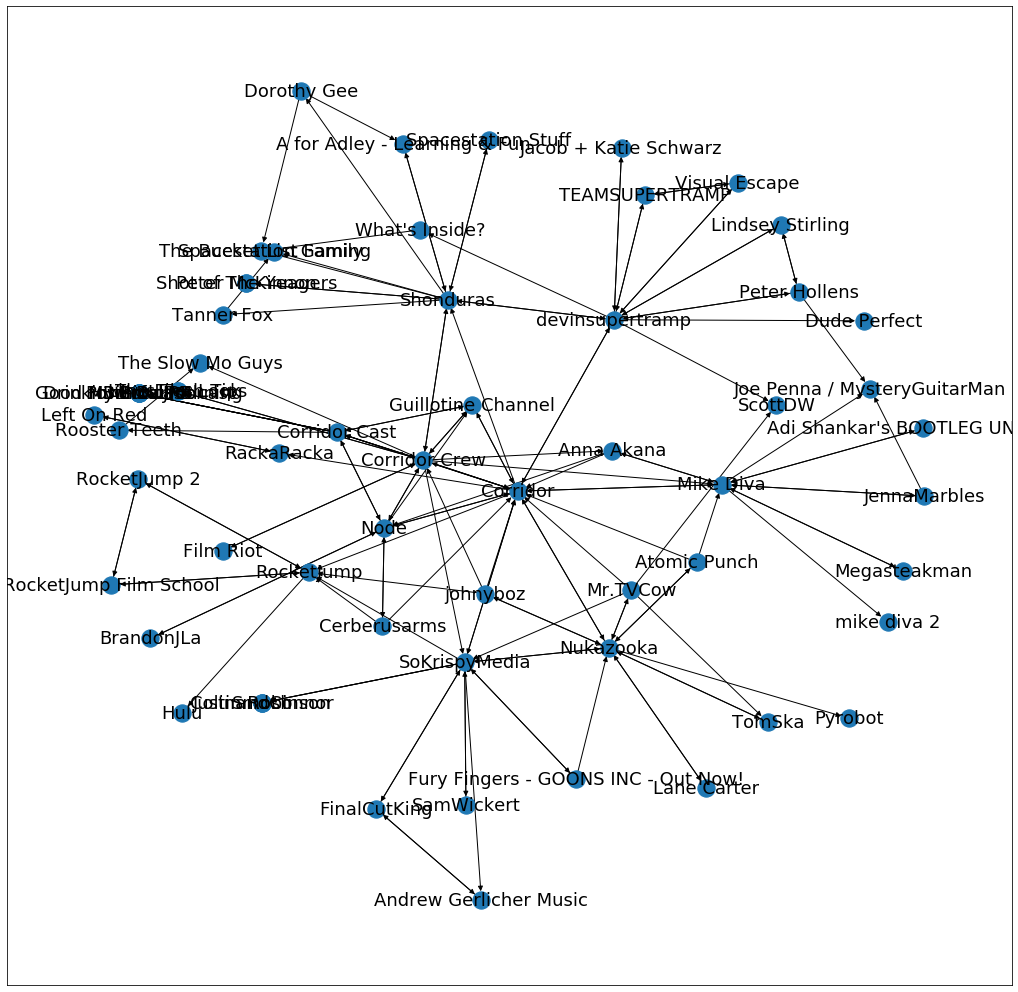

In [138]:
H = G.subgraph(CHANNELS_ID_LIST)
plt.figure(figsize = (18,18))
POS = nx.drawing.layout.kamada_kawai_layout(H)
nx.set_node_attributes(H, POS, name='pos')
nx.set_node_attributes(H, CHANNEL_NAMES, name='title')
nx.draw_networkx(H,
             with_labels=True,
             pos=POS,
             labels=CHANNEL_NAMES,
             font_size=18, font_color = 'k')

In [119]:
import plotly.graph_objects as go

In [ ]:
def plotly_network_graph(g):
    edge_x = []
    edge_y = []
    for edge in H.edges():
        x0, y0 = H.nodes[edge[0]]['pos']
        x1, y1 = H.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_x = []
    node_y = []
    for node in H.nodes():
        x, y = H.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title='<br>Network graph made with Python',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

In [143]:
edge_x = []
edge_y = []
for edge in H.edges():
    x0, y0 = H.nodes[edge[0]]['pos']
    x1, y1 = H.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

In [144]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [145]:
node_x = []
node_y = []
for node in H.nodes():
    x, y = H.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
for node, adjacencies in enumerate(H.adjacency()):
    print(adjacencies[0])

In [154]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(H.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'{CHANNEL_NAMES[adjacencies[0]]} has # of connections: {str(len(adjacencies[1]))}')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

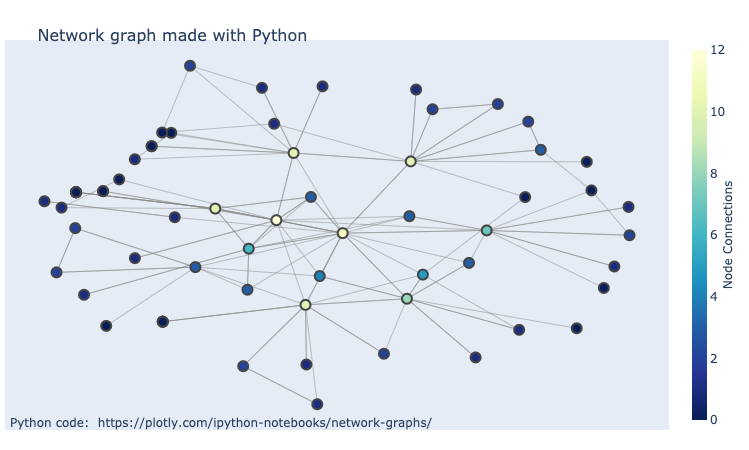

In [155]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [18]:
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_search('Corridor',50)

# Graph the network of channels
G = network_graphs.graph_channels(CHANNELS_DETAILS_ITEMS_LIST)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

features = ['id','title','description','customUrl','publishedAt','country','isLinked', 'viewCount', 'commentCount', 'subscriberCount', 'hiddenSubscriberCount','keywords','showRelatedChannels','featuredChannelsUrls', 'featuredChannelsCount']

In [48]:
PAGE_RANK_VECTOR = network_graphs.simple_page_rank(G)

0.15558966928720647
0.15695594008184363
0.06270442996743884
0.03286073451159962
0.01692671121231505
0.009919196557706143
0.005284857272617792
0.0030379695578857282
0.001626755980805569
0.0009267822482785635
0.0004974141047513391
0.0002820304571672055
0.00015191275278262308
8.600032636397628e-05
4.661125602236717e-05
2.6416476416300127e-05
1.4443730318074682e-05
8.210327308526807e-06
4.536470671761566e-06
2.588929840913161e-06


In [49]:
CHANNELIDS = list(G.nodes().keys())
vector = pd.Series(data = PAGE_RANK_VECTOR, index = CHANNELIDS)

In [52]:
DF['v1'] = DF['id'].map(lambda x:vector[x])

In [53]:
DF[['title','id','subscriberCount','viewCount','v1','featuredChannelsCount']].sort_values('v1', ascending=False).head(20)

,title,id,subscriberCount,viewCount,v1,featuredChannelsCount
0,Corridor,UCsn6cjffsvyOZCZxvGoJxGg,8060000,1463046799,0.101940,11
4,Corridor Crew,UCSpFnDQr88xCZ80N-X7t0nQ,4090000,706000450,0.095757,12
10,Node,UCI4Wh0EQPjGx2jJLjmTsFBQ,3260000,798468842,0.075889,6
1,Corridor Cast,UCNSeDrWRGxx5p2l3tj7RWQw,110000,4989413,0.067070,10
8,Nukazooka,UCQqi--mpTFtGNim0WCtPH-A,2250000,669066458,0.063303,8
11,Guillotine Channel,UCb8ewylk7d2M_1dLGEiFmuQ,224000,3057916,0.054179,3
40,johnyboz,UC6sokr_zvkvLdhTfJD2QC_w,3020,282099,0.053408,7
51,Mr.TVCow,UCUtUVnGVHrc83t1r0p5r7ww,1570000,505997122,0.045104,8
37,Anna Akana,UCZC45sBWNdkqSQ9Bwtt5lfA,2700000,334033239,0.043346,8
5,SoKrispyMedia,UCKo61AAaRD00ibCWJZ321MQ,1130000,315476266,0.042223,10


In [ ]:
# Request n number of channels from a youtube search
CHANNELS_LIST = youtube_request_search_channels('Corridor Digital',20)

# Retrieve Channel Ids from the list of dictionaries
CHANNELS_ID_LIST = [channel['snippet']['channelId'] for channel in CHANNELS_LIST]

# Request details from each channel
CHANNEL_DETAILS_ITEMS_LIST = youtube_request_channel_list(CHANNELS_ID_LIST)

# Extract channel details to a list of dictionaries for pandas
CHANNELS_DETAILS_LIST = extract_channel_details(CHANNEL_DETAILS_ITEMS_LIST)

#### Return a detail_items list of channels associated to query and number of results

In [ ]:
# Get 20 channels related to query through search
CHANNELS_DETAILS_ITEMS_LIST = youtube_channel_details_by_search("MSNBC", 20)
CHANNELS_DETAILS_ITEMS_LIST[0]

# Get n-degree network
corridor_2_network = youtube_channel_details_by_network([CHANNELS_DETAILS_ITEMS_LIST[0]],2)
nbc_2_network = youtube_channel_details_by_network([CHANNELS_DETAILS_ITEMS_LIST[0]],2)

In [ ]:
# Checking for uniqueness
[channel['snippet']['title'] for channel in corridor_2_network]

In [ ]:
a = {1,2,3}

In [ ]:
b = {4,1,2,7}

In [ ]:
a.difference(b.intersection(a))

In [ ]:
b = b|

In [ ]:
b

In [ ]:
b.difference(a)

In [ ]:
youtube_channel_details_by_network()

## NetworkX

In [ ]:
# change function for producing positional argument.
POS = nx.drawing.layout.circular_layout(G)

In [ ]:
G = graph_channels(nbc_2_network)

In [ ]:
def simple_page_rank(g):
    a = nx.adjacency_matrix(g)
    n, _ = a.shape
    v0 = np.ones(n) / n
    for i in range(20):
        v1 = a @ v0
        v1 /= v1.sum(0)
        print(np.linalg.norm(v1 - v0))
        v0 = v1
    return v1

In [ ]:
V1 = simple_page_rank(G)

In [ ]:
vector

In [ ]:
DF['id']

In [ ]:
DF.shape

In [ ]:
vector['UCF8wBg64pAc2ktRuPbW7qDg']

In [ ]:
CHANNELIDS = list(G.nodes().keys())
vector = pd.Series(data = V1, index = CHANNELIDS)


In [ ]:
DF['v1'] = DF['id'].map(lambda x:vector[x])

In [ ]:
len(CHANNELIDS)

In [ ]:
DF[['title','id','subscriberCount','viewCount','v1','featuredChannelsCount']].sort_values('v1', ascending=False).head(20)

# Connected Components

In [ ]:
import collections
def run():
    sizes = []
    ccs = []
    for cc in nx.connected_components(G.to_undirected()):
        ccs.append(cc)
        sizes.append(len(cc))
    print(sorted(sizes))
    return ccs#collections.Counter(sizes)

CCS = run()

In [ ]:
plt.figure(figsize = (12,12))
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)),
                 with_labels=False)
                 #labels=CHANNEL_NAMES,
                 #font_size=12, font_color = 'red')

In [ ]:
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)))

In [ ]:
CHANNELS_DETAILS_LIST = extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Exploring the data

In [ ]:
def create_dataframe(channel_details_list):
    df = pd.DataFrame(channel_details_list)
    df['videoCount'] = df['videoCount'].map(lambda x: int(x))
    df['commentCount'] = df['commentCount'].map(lambda x: int(x))
    df['viewCount'] = df['viewCount'].map(lambda x: int(x))
    df['subscriberCount'] = df['subscriberCount'].map(lambda x: int(x))
    df['featuredChannelsCount'] = df['featuredChannelsUrls'].apply(lambda x: 0 if type(x) == float else len(x))
    return df

features = ['id','title','description','customUrl','publishedAt','country','isLinked', 'viewCount', 'commentCount', 'subscriberCount',
           'hiddenSubscriberCount','keywords','showRelatedChannels','featuredChannelsUrls', 'featuredChannelsCount']

CHANNELS_DETAILS_LIST = extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)
DF = create_dataframe(CHANNELS_DETAILS_LIST)
DF.shape

In [ ]:
DF.info()

In [ ]:
DF[features].sort_values(by='subscriberCount', ascending = False).head(5)

In [ ]:
sns.distplot(DF['subscriberCount'].map(lambda x: np.log(x+1)))

In [ ]:
sns.distplot(DF['viewCount'].map(lambda x: np.log(x+1)))

In [ ]:
plt.scatter(DF['subscriberCount'], DF['viewCount'])

In [ ]:
plt.barh(DF['title'], DF['subscriberCount'])